# **Example : Breast cancer dataset**


## Context
**Risk-score model** are one of the most explicit/explanable model, and are used in psychology, medicine or justice.  
The score of such model is computed via a sum of points, which are defined for each binary feature.  
For each possible score value, risk-score model gives a probability of belonging to the positive class.

----

This notebook displays the usage of the scorepyo package on the breast cancer dataset.

It shows two different components:
* Automatic feature binarizer
* Score card model

### Automatic feature binarizer
A risk-score type model can only be constructed based on binary features.  In most cases, datasets are constructed with a mix of continuous, categorical and binary features.  
From there, we either manually engineer the binary features, or we can automatically construct them.

A risk-score model is an additive model, therefore we need to craft binary features such that they help to predict by adding their contribution, modulo a coefficient. This corresponds to General Additive Model (GAM), that's why The `AutomaticBinaryFeaturizer` class is based on a GAM that predicts the binary target.  
The GAM used is an Explainable Boosting Machine (EBM), as EBM are good candidates for such a task. Indeed the individual feature function in EBMs is a single-feature tree. Binary features can be extracted by using the feature value intervals used to construct each single-feature tree. 

### Score card model
The scorepyo package aims to provide several ways to construct a risk-score model. 

The first one implemented is via the `OptunaScoreCard` class. This class leverages the efficient sampling abilities of Optuna to select both binary features and their associated points amount.

In [1]:
%load_ext autoreload
%autoreload 2

### Load dataset

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
data_X, y = data.data, data.target

X = pd.DataFrame(data=data_X, columns = data.feature_names)

### Create artificial categorical variable

In [3]:
X['category'] = np.where(X['mean smoothness'] <=0.1,'A','B')

### Split train/test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

#### Create unknown category in test set

In [5]:
X_test['category']='C'

### Create automatically binary features 

The bnary feature creation is based on train dataset to detect them.  
The train and tests dataset are then transformed.

In [6]:
from scorepyo.binary_featurizer import AutomaticBinaryFeaturizer


binarizer = AutomaticBinaryFeaturizer(max_number_binaries_by_features=3,keep_negative=True)
binarizer.fit(X_train,y_train, categorical_features='auto', to_exclude_features=None)

X_train_binarized, df_info = binarizer.transform(X_train)
X_test_binarized, _ = binarizer.transform(X_test)

#### Display binarized train dataset

In [7]:
X_train_binarized.sample(3)

,mean radius < 12.26,12.26 <= mean radius < 14.66,mean radius >= 14.66,mean texture < 17.2,17.2 <= mean texture < 20.66,mean texture >= 20.66,mean perimeter < 78.69,78.69 <= mean perimeter < 95.84,mean perimeter >= 95.84,mean area < 462.45,...,0.08 <= worst concave points < 0.14,worst concave points >= 0.14,worst symmetry < 0.26,0.26 <= worst symmetry < 0.3,worst symmetry >= 0.3,worst fractal dimension < 0.07,0.07 <= worst fractal dimension < 0.09,worst fractal dimension >= 0.09,category_A,category_B
428,1,0,0,1,0,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1.0,0.0
147,0,0,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,1.0,0.0
40,0,1,0,0,0,1,0,1,0,0,...,1,0,0,1,0,1,0,0,1.0,0.0


### Display information from binarizer

The binarizer also outputs a dataframe containing information about the binarizer. 
This information can be later used to for the display of the `OptunaScoreCard` model.

In [8]:
df_info

,EBM_log_odds_contribution,lower_threshold,upper_threshold,feature
binary_feature,,,,
mean radius < 12.26,0.135708,NaN,12.26,mean radius
12.26 <= mean radius < 14.66,0.086529,12.26,14.66,mean radius
mean radius >= 14.66,-0.222237,14.66,NaN,mean radius
mean texture < 17.2,0.740917,NaN,17.205,mean texture
17.2 <= mean texture < 20.66,0.056726,17.205,20.665,mean texture
...,...,...,...,...
0.07 <= worst fractal dimension < 0.09,0.372596,0.07428,0.08649,worst fractal dimension
worst fractal dimension >= 0.09,-0.156302,0.08649,NaN,worst fractal dimension
category_A,None,None,None,category


#### Train ScoreCard model

The ScoreCard models can take 4 parameters:
* `nb_max_features` : number of maximum binary features to use for the score card
* `min_point_value` : minimum possible number of points for each binary feature
* `max_point_value` : maximum possible number of points for each binary feature
* `df_info`         : optional dataframe containing the correspondance between original feature and the binary feature. It must contain 2 columns *feature* and *binary_feature*.

Since the `OptunaScoreCard` model is based on Optuna, we can also pass specific optuna optimize function parameters via a dictionnary in the  `optuna_optimize_params` parameter.

In [9]:
from scorepyo.models import OptunaScoreCard


scorepyo_model = OptunaScoreCard(nb_max_features=4, min_point_value=-1, max_point_value=2, df_info=df_info['feature'].reset_index())

scorepyo_model.fit(X_train_binarized, y_train)


c:\Users\S5384228\Anaconda3\envs\env_scorepyo_ci\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Display the summary of the score card model

The summary of the score card built by the model.  

It displays two elements :
* Feature-point card : Points for each selected binary feature
* Score card : Scores (=sum of points) with their associated probability

In [10]:
scorepyo_model.summary()

| FEATURE-POINT CARD |
| feature              | Description                  |   point |
|:---------------------|:-----------------------------|--------:|
| worst concave points | worst concave points >= 0.14 |      -1 |
| concavity error      | concavity error < 0.02       |       2 |


|     SCORE CARD     |
| SCORE   | -1     | 0      | 1      | 2      |
|:--------|:-------|:-------|:-------|:-------|
| RISK    | 50.00% | 73.11% | 88.08% | 95.26% |


#### Precision-Recall curve on test set

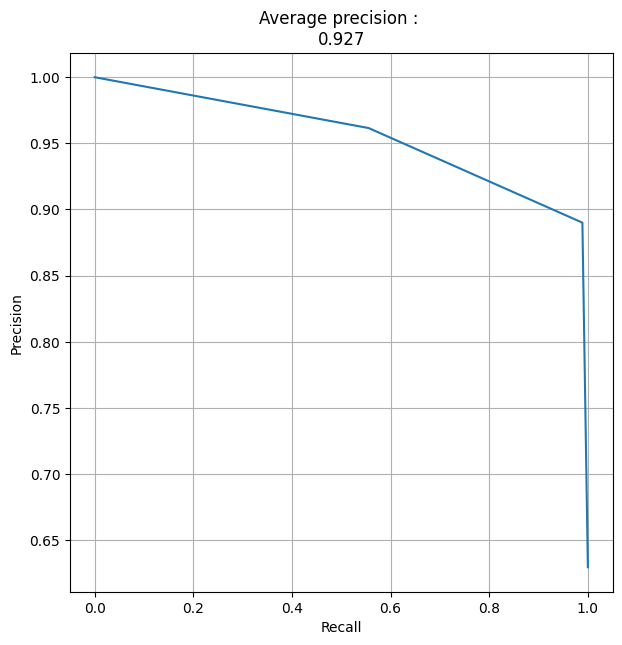

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


y_proba = scorepyo_model.predict_proba(X_test_binarized)[:, 1].reshape(-1,1)

precision, recall, thresholds = precision_recall_curve(y_test.astype(int), y_proba)
fig, ax = plt.subplots(figsize=(7, 7))
plt.plot(recall, precision)
average_precision = np.round(average_precision_score(y_test.astype(int),y_proba),3)
title_PR_curve = f'Average precision : \n{average_precision}'
plt.title(title_PR_curve)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()